In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision torchaudio
!pip install torch-geometric

# torch-scatter torch-sparse torch-cluster torch-spline-conv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import os
import pandas as pd

# Paths
interactions_csv = '/content/drive/MyDrive/Colab_Notebooks/GNN/GraphsClassification - PPIGraphNet/data/protein_graphs/metadata.csv'
graphs_folder = '/content/drive/MyDrive/Colab_Notebooks/GNN/GraphsClassification - PPIGraphNet/data/protein_graphs'

# Load interactions file
interactions_df = pd.read_csv(interactions_csv)

# Get list of graph filenames
existing_graphs = {os.path.splitext(f)[0] for f in os.listdir(graphs_folder)}

# Filter interactions for valid pairs
valid_interactions = interactions_df[
    interactions_df['protein1_pdb'].isin(existing_graphs) &
    interactions_df['protein2_pdb'].isin(existing_graphs)
]

# Save the filtered interactions
valid_interactions.to_csv('/content/drive/MyDrive/Colab_Notebooks/GNN/GraphsClassification - PPIGraphNet/data/protein_graphs/filtered_interactions.csv', index=False)
print("Filtered interactions saved.")
print("Number of valid interactions:", len(valid_interactions))

Filtered interactions saved.
Number of valid interactions: 87996


In [4]:
import pandas as pd

# Paths
interactions_csv = '/content/drive/MyDrive/Colab_Notebooks/GNN/GraphsClassification - PPIGraphNet/data/protein_graphs/metadata.csv'
graphs_folder = '/content/drive/MyDrive/Colab_Notebooks/GNN/GraphsClassification - PPIGraphNet/data/protein_graphs/'

# Load the filtered interactions
interactions_df = pd.read_csv(interactions_csv)

# Prepare lists
protein1_list = interactions_df['protein1_pdb'].tolist()
protein2_list = interactions_df['protein2_pdb'].tolist()
interaction_list = interactions_df['interaction_type'].tolist()

print(f"Protein 1 count: {len(protein1_list)}, Protein 2 count: {len(protein2_list)}, Interactions: {len(interaction_list)}")
print(f"First 5 Protein 1: {protein1_list[:5]}, First 5 Protein 2: {protein2_list[:5]}, First 5 Interactions: {interaction_list[:5]}")
print(interactions_df.head())

Protein 1 count: 87996, Protein 2 count: 87996, Interactions: 87996
First 5 Protein 1: ['4MVB', '4MVB', '4MVB', '4MVB', '4MVB'], First 5 Protein 2: ['1BQH', '1BZ9', '1DDH', '1FFO', '1FO0'], First 5 Interactions: [0, 0, 0, 0, 0]
  protein1_pdb protein2_pdb protein1_uniprot protein2_uniprot  \
0         4MVB         1BQH           A0A5B9           P01887   
1         4MVB         1BZ9           A0A5B9           P01887   
2         4MVB         1DDH           A0A5B9           P01887   
3         4MVB         1FFO           A0A5B9           P01887   
4         4MVB         1FO0           A0A5B9           P01887   

   interaction_type  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  


In [5]:
# Randomly select 15000 rows/interactions only [Google colab constraint on memory]
interactions_df = interactions_df.sample(n=5000, random_state=42)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load metadata
df = interactions_df.copy()

# Create canonical pair ID
df["pair_id"] = df.apply(
    lambda row: "_".join(sorted([row["protein1_uniprot"], row["protein2_uniprot"]])),
    axis=1
)

# Stratified split on unique pairs
unique_pairs = df[["pair_id", "interaction_type"]].drop_duplicates()
train_ids, test_ids = train_test_split(
    unique_pairs,
    test_size=0.2,
    stratify=unique_pairs["interaction_type"],
    random_state=42
)

# Filter original dataframe
train_df = df[df["pair_id"].isin(train_ids["pair_id"])]
test_df = df[df["pair_id"].isin(test_ids["pair_id"])]

# Optional: drop the helper column
train_df = train_df.drop(columns=["pair_id"])
test_df = test_df.drop(columns=["pair_id"])

print(f"Train set size: {len(train_df)}, Test set size: {len(test_df)}")
print(train_df.head())

print(train_df["interaction_type"].value_counts())
print(test_df["interaction_type"].value_counts())

Train set size: 4321, Test set size: 679
      protein1_pdb protein2_pdb protein1_uniprot protein2_uniprot  \
74488         3GSW         3BH9           P61769           Q8WVV4   
61230         2OFZ         4NO2           P59595           P61769   
80467         7B1J         6V69           Q9Y6D9           Q9UGJ1   
35957         2AQ3         1HHH           P04213           P61769   
42522         4AZ3         6VB7           P10619           P61769   

       interaction_type  
74488                 0  
61230                 0  
80467                 1  
35957                 0  
42522                 0  
interaction_type
0    3958
1     363
Name: count, dtype: int64
interaction_type
0    590
1     89
Name: count, dtype: int64


In [7]:
import torch
from torch_geometric.data import Data
import os

def pt_to_pyg(graph_pt_dir, interactions_df):
    data_p1 = []
    data_p2 = []
    labels = []

    count = 1

    for _, row in interactions_df.iterrows():
        print(f"Processing row {count}"); count += 1

        pdb1 = row["protein1_pdb"]
        pdb2 = row["protein2_pdb"]
        label = row["interaction_type"]

        pt1_path = os.path.join(graph_pt_dir, f"{pdb1}.pt")
        pt2_path = os.path.join(graph_pt_dir, f"{pdb2}.pt")

        if os.path.isfile(pt1_path) and os.path.isfile(pt2_path):
            try:
                g1 = torch.load(pt1_path, weights_only=False)
                g2 = torch.load(pt2_path, weights_only=False)

                # Optionally check if the objects are valid Data objects
                if isinstance(g1, Data) and isinstance(g2, Data):
                    data_p1.append(g1)
                    data_p2.append(g2)
                    labels.append(label)
                    print(f"Loaded {pdb1} and {pdb2}")
            except Exception as e:
                print(f"Error loading {pdb1} or {pdb2}: {e}")
        else:
            print(f"Missing file(s): {pdb1}.pt or {pdb2}.pt")

    return data_p1, data_p2, labels


In [8]:
# Example usage
pt_dir = '/content/drive/MyDrive/Colab_Notebooks/GNN/GraphsClassification - PPIGraphNet/data/protein_graphs/'  # Path to the directory containing GraphML files

# Convert GraphML files to PyTorch Geometric format
train_graph_data_p1, train_graph_data_p2, train_graph_data_interaction  = pt_to_pyg(pt_dir, train_df)
test_graph_data_p1, test_graph_data_p2, test_graph_data_interaction  = pt_to_pyg(pt_dir, test_df)

Streaming output truncated to the last 5000 lines.
Processing row 2501
Loaded 1K8D and 1TVH
Processing row 2502
Loaded 1TVH and 3TO2
Processing row 2503
Loaded 3I6K and 2XPG
Processing row 2504
Loaded 3MRI and 5TC7
Processing row 2505
Loaded 4AZ3 and 3MR9
Processing row 2506
Loaded 6J2E and 1W0W
Processing row 2507
Loaded 3H7B and 3NFN
Processing row 2508
Loaded 6KGJ and 8ARZ
Processing row 2509
Loaded 2UZQ and 3NFN
Processing row 2510
Loaded 2WL0 and 8A7O
Processing row 2511
Loaded 2FZ3 and 3MRQ
Processing row 2512
Loaded 3LZS and 6MTM
Processing row 2513
Loaded 3BH8 and 3KPL
Processing row 2514
Loaded 2NW2 and 6M2J
Processing row 2515
Loaded 2OFZ and 6FGB
Processing row 2516
Loaded 1D9K and 3LKR
Processing row 2517
Loaded 6OJP and 1FZO
Processing row 2518
Loaded 5ELT and 4I7D
Processing row 2519
Loaded 3CZF and 5TXS
Processing row 2520
Loaded 3RL1 and 6RPA
Processing row 2521
Loaded 3PAB and 1S7S
Processing row 2522
Loaded 1WBX and 1RJZ
Processing row 2523
Loaded 1LD9 and 1T0N
Proces

In [9]:
print(len(train_graph_data_p1))
print(len(train_graph_data_p2))
print(len(train_graph_data_interaction))

print(type(train_graph_data_p1[0]))
print(type(train_graph_data_p2[0]))
print(type(train_graph_data_interaction[0]))

4321
4321
4321
<class 'torch_geometric.data.data.Data'>
<class 'torch_geometric.data.data.Data'>
<class 'int'>


In [10]:
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.loader import DataLoader

class PPI_GraphDataset(torch.utils.data.Dataset):
    """
    A PyTorch Dataset for Protein-Protein Interaction (PPI) graphs.
    Contains the graphs for protein1, protein2, and their corresponding interaction types.
    """
    def __init__(self, graph_data_p1, graph_data_p2, interaction_data):
        """
        Args:
            graph_data_p1 (list): List of protein1 graphs.
            graph_data_p2 (list): List of protein2 graphs.
            interaction_data (list): List of interaction types (labels).
        """
        self.graph_data_p1 = graph_data_p1
        self.graph_data_p2 = graph_data_p2
        self.interaction_data = interaction_data

    def __len__(self):
        return len(self.graph_data_p1)

    def __getitem__(self, idx):
        """
        Fetch a single sample from the dataset. Returns the graphs and interaction type.
        """
        # Fetch the individual graphs and interaction label
        graph1 = self.graph_data_p1[idx]
        graph2 = self.graph_data_p2[idx]
        interaction_type = self.interaction_data[idx]

        # Return a tuple of (graph1, graph2, interaction_type)
        return graph1, graph2, interaction_type

"""
# Create the Dataset for the training set and for the test set
train_dataset = PPI_GraphDataset(train_graph_data_p1, train_graph_data_p2, train_graph_data_interaction)
test_dataset = PPI_GraphDataset(test_graph_data_p1, test_graph_data_p2, test_graph_data_interaction)

# Create DataLoader for batching
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train loader length: {len(train_loader)}, Test loader length: {len(test_loader)}")
"""

'\n# Create the Dataset for the training set and for the test set\ntrain_dataset = PPI_GraphDataset(train_graph_data_p1, train_graph_data_p2, train_graph_data_interaction)\ntest_dataset = PPI_GraphDataset(test_graph_data_p1, test_graph_data_p2, test_graph_data_interaction)\n\n# Create DataLoader for batching\nbatch_size = 16\n\ntrain_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)\ntest_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)\n\nprint(f"Train loader length: {len(train_loader)}, Test loader length: {len(test_loader)}")\n'

In [11]:
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.nn import GCNConv
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class PPIGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super(PPIGCN, self).__init__()
        # Shared encoder for both graphs
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, data1, data2):

        # Encode protein 1
        x1 = F.relu(self.conv1(data1.x, data1.edge_index))
        x1 = F.relu(self.conv2(x1, data1.edge_index))
        x1 = global_mean_pool(x1, data1.batch)

        # Encode protein 2
        x2 = F.relu(self.conv1(data2.x, data2.edge_index))
        x2 = F.relu(self.conv2(x2, data2.edge_index))
        x2 = global_mean_pool(x2, data2.batch)

        # Concatenate both graph embeddings
        x = torch.cat([x1, x2], dim=1)
        out = self.classifier(x)
        return out.squeeze()


In [13]:
import torch
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

def custom_collate(batch):
    data1_list = [item[0] for item in batch]
    data2_list = [item[1] for item in batch]
    labels = torch.tensor([item[2] for item in batch], dtype=torch.float)
    return data1_list, data2_list, labels

# Helper function to plot the loss curve
def plot_loss_curve(all_losses, title='Loss Curves for Each Fold'):
    for i, losses in enumerate(all_losses):
        plt.plot(losses, label=f'Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()


In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm

def cross_validate_model(X1, X2, y, batch_size, epochs, learning_rate=0.001, k_folds=5, thresh_1 = 0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print('Device:',device)
    #device = torch.device("cpu"); print('Device:',device)

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True)

    all_losses = []  # To store loss curves for each fold
    all_auroc = []
    all_precision = []
    all_recall = []
    all_f1 = []
    all_val_losses = []  # To store validation loss for each fold

    # Stratified k-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(X1, y)):
        print(f"Training Fold {fold + 1}/{k_folds}")

        # Split the data into training and validation sets
        X1_train = [X1[i] for i in train_idx]
        X2_train = [X2[i] for i in train_idx]
        y_train = [y[i] for i in train_idx]
        train_dataset = PPI_GraphDataset(X1_train, X2_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

        X1_val = [X1[i] for i in val_idx]
        X2_val = [X2[i] for i in val_idx]
        y_val = [y[i] for i in val_idx]
        val_dataset = PPI_GraphDataset(X1_val, X2_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate)

        # Initialize the model, loss function, and optimizer
        print(f'Initializing model with {train_dataset[0][0].num_node_features} features \n\n')
        model = PPIGCN(input_dim=train_dataset[0][0].num_node_features, hidden_dim=64).to(device)  # Adjust these parameters based on your data

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = torch.nn.BCELoss()  # Binary Cross Entropy loss (with sigmoid output)

        fold_losses = []
        fold_train_auroc = []
        fold_train_precision = []
        fold_train_recall = []
        fold_train_f1 = []
        fold_val_losses = []  # To store validation losses for each epoch

        # Training loop for each fold
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")

            # Train the model and collect predictions
            model.train()
            train_losses = []
            y_true_train = []
            y_pred_train = []

            for data1, data2, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} of training", leave=False):
                data1.x = data1.x.float(); data2.x = data2.x.float();
                labels = labels.float()  # Ensure labels are float for BCE loss

                data1 = data1.to(device)
                data2 = data2.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(data1, data2)  # Assuming model already applies sigmoid and squeeze
                outputs = outputs.view(-1)  # Always keeps it as a 1D tensor

                loss = criterion(outputs, labels)  # Use the output directly
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())

                # Collect true labels and predictions for metrics
                y_true_train.extend(labels.cpu().numpy())
                y_pred_train.extend(outputs.detach().cpu().numpy())  # Directly use outputs (already sigmoid)

            # Convert predictions to binary labels
            y_pred_train_binary = [1 if p > thresh_1 else 0 for p in y_pred_train]

            # Calculate training metrics
            train_precision = precision_score(y_true_train, y_pred_train_binary, zero_division=0)
            train_recall = recall_score(y_true_train, y_pred_train_binary, zero_division=0)
            train_f1 = f1_score(y_true_train, y_pred_train_binary, zero_division=0)
            train_auroc = roc_auc_score(y_true_train, y_pred_train)

            # Append training metrics and loss
            fold_train_auroc.append(train_auroc)
            fold_train_precision.append(train_precision)
            fold_train_recall.append(train_recall)
            fold_train_f1.append(train_f1)
            fold_losses.append(sum(train_losses) / len(train_losses))

            # Print training metrics for this epoch
            print(f"Training - Loss: {sum(train_losses) / len(train_losses):.4f}, "
                  f"AUROC: {train_auroc:.4f}, Precision: {train_precision:.4f}, "
                  f"Recall: {train_recall:.4f}, F1: {train_f1:.4f}")

            # Validation loop for each epoch
            model.eval()
            y_true_val = []
            y_pred_val = []
            val_losses = []  # List to store validation losses for the current epoch
            with torch.no_grad():
                for data1, data2, labels in val_loader:
                    data1.x = data1.x.float(); data2.x = data2.x.float()
                    labels = labels.float()  # Ensure labels have shape [batch_size, 1]

                    data1 = data1.to(device)
                    data2 = data2.to(device)
                    labels = labels.to(device)

                    outputs = model(data1, data2)  # Assuming model applies sigmoid
                    outputs = outputs.view(-1)  # Always keeps it as a 1D tensor

                    loss = criterion(outputs, labels)  # Calculate loss for the validation batch
                    val_losses.append(loss.item())  # Append to val_losses list

                    # Collect true labels and predictions for metrics
                    y_true_val.extend(labels.cpu().numpy())
                    y_pred_val.extend(outputs.detach().cpu().numpy())  # Directly use outputs (already sigmoid)

            # Convert to binary predictions for validation metrics
            y_pred_val_binary = [1 if p > thresh_1 else 0 for p in y_pred_val]

            # Calculate validation metrics
            val_precision = precision_score(y_true_val, y_pred_val_binary, zero_division=0)
            val_recall = recall_score(y_true_val, y_pred_val_binary, zero_division=0)
            val_f1 = f1_score(y_true_val, y_pred_val_binary, zero_division=0)
            val_auroc = roc_auc_score(y_true_val, y_pred_val)

            # Append validation loss and metrics
            fold_val_losses.append(sum(val_losses) / len(val_losses))

            # Print validation metrics after every epoch
            print(f"Validation - Loss: {sum(val_losses) / len(val_losses):.4f}, "
                  f"AUROC: {val_auroc:.4f}, Precision: {val_precision:.4f}, "
                  f"Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        # Store metrics for each fold
        all_losses.append(fold_losses)
        all_auroc.append(val_auroc)
        all_precision.append(val_precision)
        all_recall.append(val_recall)
        all_f1.append(val_f1)
        all_val_losses.append(fold_val_losses)  # Store the fold's validation losses

        print(f"Fold {fold + 1} - Final Validation - AUROC: {val_auroc:.4f}, "
              f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f} \n\n")

    # Plot the loss curve for each fold
    plot_loss_curve(all_losses)

    # Plot the validation loss curve
    plot_loss_curve(all_val_losses, title="Validation Loss Curve")

    # Calculate and print average metrics
    print(f"Average AUROC: {sum(all_auroc) / k_folds:.4f}")
    print(f"Average Precision: {sum(all_precision) / k_folds:.4f}")
    print(f"Average Recall: {sum(all_recall) / k_folds:.4f}")
    print(f"Average F1 Score: {sum(all_f1) / k_folds:.4f}")
    print(f"Average Validation Loss: {sum([sum(fold_losses) for fold_losses in all_val_losses]) / (len(all_val_losses) * epochs):.4f}")

    return model


Device: cuda
Training Fold 1/3
Initializing model with 7 features 


Epoch 1/20


Training - Loss: 0.3024, AUROC: 0.5156, Precision: 0.1875, Recall: 0.0124, F1: 0.0233
Validation - Loss: 0.2854, AUROC: 0.6951, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 2/20


Training - Loss: 0.2919, AUROC: 0.5317, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2847, AUROC: 0.7520, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 3/20


Training - Loss: 0.2846, AUROC: 0.5878, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2887, AUROC: 0.8158, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 4/20


Training - Loss: 0.2828, AUROC: 0.6127, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2762, AUROC: 0.8216, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 5/20


Training - Loss: 0.2795, AUROC: 0.6392, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2672, AUROC: 0.8486, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 6/20


Training - Loss: 0.2677, AUROC: 0.7271, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2590, AUROC: 0.8549, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 7/20


Training - Loss: 0.2511, AUROC: 0.8338, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2351, AUROC: 0.8510, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 8/20


Training - Loss: 0.2300, AUROC: 0.8438, Precision: 0.4286, Recall: 0.0124, F1: 0.0241
Validation - Loss: 0.2219, AUROC: 0.8614, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 9/20


Training - Loss: 0.2091, AUROC: 0.8748, Precision: 0.6571, Recall: 0.0950, F1: 0.1661
Validation - Loss: 0.2160, AUROC: 0.8691, Precision: 0.7778, Recall: 0.0579, F1: 0.1077
Epoch 10/20


Training - Loss: 0.1956, AUROC: 0.9028, Precision: 0.5977, Recall: 0.2149, F1: 0.3161
Validation - Loss: 0.2022, AUROC: 0.8775, Precision: 0.7600, Recall: 0.1570, F1: 0.2603
Epoch 11/20


Training - Loss: 0.1758, AUROC: 0.9243, Precision: 0.6733, Recall: 0.2810, F1: 0.3965
Validation - Loss: 0.1903, AUROC: 0.8828, Precision: 0.7895, Recall: 0.2479, F1: 0.3774
Epoch 12/20


Training - Loss: 0.1709, AUROC: 0.9209, Precision: 0.6567, Recall: 0.3636, F1: 0.4681
Validation - Loss: 0.1915, AUROC: 0.8960, Precision: 0.5701, Recall: 0.5041, F1: 0.5351
Epoch 13/20


Training - Loss: 0.1590, AUROC: 0.9347, Precision: 0.6690, Recall: 0.3926, F1: 0.4948
Validation - Loss: 0.1727, AUROC: 0.8980, Precision: 0.6875, Recall: 0.4545, F1: 0.5473
Epoch 14/20


Training - Loss: 0.1586, AUROC: 0.9295, Precision: 0.7372, Recall: 0.4752, F1: 0.5779
Validation - Loss: 0.1781, AUROC: 0.8996, Precision: 0.8298, Recall: 0.3223, F1: 0.4643
Epoch 15/20


Training - Loss: 0.1610, AUROC: 0.9287, Precision: 0.7467, Recall: 0.4628, F1: 0.5714
Validation - Loss: 0.1763, AUROC: 0.9016, Precision: 0.8367, Recall: 0.3388, F1: 0.4824
Epoch 16/20


Training - Loss: 0.1529, AUROC: 0.9402, Precision: 0.6821, Recall: 0.4876, F1: 0.5687
Validation - Loss: 0.1677, AUROC: 0.9060, Precision: 0.7846, Recall: 0.4215, F1: 0.5484
Epoch 17/20


Training - Loss: 0.1478, AUROC: 0.9441, Precision: 0.7273, Recall: 0.4959, F1: 0.5897
Validation - Loss: 0.1849, AUROC: 0.9049, Precision: 0.8367, Recall: 0.3388, F1: 0.4824
Epoch 18/20


Training - Loss: 0.1464, AUROC: 0.9417, Precision: 0.7416, Recall: 0.5455, F1: 0.6286
Validation - Loss: 0.1602, AUROC: 0.9143, Precision: 0.6854, Recall: 0.5041, F1: 0.5810
Epoch 19/20


Training - Loss: 0.1451, AUROC: 0.9439, Precision: 0.7558, Recall: 0.5372, F1: 0.6280
Validation - Loss: 0.1587, AUROC: 0.9177, Precision: 0.6854, Recall: 0.5041, F1: 0.5810
Epoch 20/20


Training - Loss: 0.1384, AUROC: 0.9469, Precision: 0.7189, Recall: 0.5496, F1: 0.6230
Validation - Loss: 0.1677, AUROC: 0.9228, Precision: 0.5923, Recall: 0.6364, F1: 0.6135
Fold 1 - Final Validation - AUROC: 0.9228, Precision: 0.5923, Recall: 0.6364, F1: 0.6135 


Training Fold 2/3
Initializing model with 7 features 


Epoch 1/20


Training - Loss: 0.3000, AUROC: 0.5215, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2852, AUROC: 0.7707, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 2/20


Training - Loss: 0.2971, AUROC: 0.5575, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.3009, AUROC: 0.8346, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 3/20


Training - Loss: 0.2893, AUROC: 0.5514, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2816, AUROC: 0.8587, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 4/20


Training - Loss: 0.2818, AUROC: 0.6246, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2798, AUROC: 0.8395, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 5/20


Training - Loss: 0.2762, AUROC: 0.6582, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2751, AUROC: 0.8289, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 6/20


Training - Loss: 0.2672, AUROC: 0.7085, Precision: 0.5000, Recall: 0.0041, F1: 0.0082
Validation - Loss: 0.2687, AUROC: 0.8549, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 7/20


Training - Loss: 0.2613, AUROC: 0.7437, Precision: 0.2857, Recall: 0.0083, F1: 0.0161
Validation - Loss: 0.2549, AUROC: 0.8755, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 8/20


Training - Loss: 0.2470, AUROC: 0.7899, Precision: 0.2500, Recall: 0.0083, F1: 0.0160
Validation - Loss: 0.2314, AUROC: 0.8958, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 9/20


Training - Loss: 0.2302, AUROC: 0.8353, Precision: 0.3333, Recall: 0.0289, F1: 0.0532
Validation - Loss: 0.2319, AUROC: 0.9118, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 10/20


Training - Loss: 0.2138, AUROC: 0.8608, Precision: 0.4333, Recall: 0.0537, F1: 0.0956
Validation - Loss: 0.1953, AUROC: 0.9240, Precision: 0.2667, Recall: 0.0331, F1: 0.0588
Epoch 11/20


Training - Loss: 0.2064, AUROC: 0.8836, Precision: 0.5600, Recall: 0.0579, F1: 0.1049
Validation - Loss: 0.1960, AUROC: 0.9329, Precision: 0.3571, Recall: 0.0413, F1: 0.0741
Epoch 12/20


Training - Loss: 0.1919, AUROC: 0.9013, Precision: 0.4959, Recall: 0.2521, F1: 0.3342
Validation - Loss: 0.1679, AUROC: 0.9412, Precision: 0.5857, Recall: 0.3388, F1: 0.4293
Epoch 13/20


Training - Loss: 0.1845, AUROC: 0.9071, Precision: 0.5922, Recall: 0.2521, F1: 0.3536
Validation - Loss: 0.2419, AUROC: 0.9397, Precision: 0.5714, Recall: 0.0331, F1: 0.0625
Epoch 14/20


Training - Loss: 0.1831, AUROC: 0.9066, Precision: 0.6852, Recall: 0.3058, F1: 0.4229
Validation - Loss: 0.1996, AUROC: 0.9421, Precision: 0.6154, Recall: 0.0661, F1: 0.1194
Epoch 15/20


Training - Loss: 0.1711, AUROC: 0.9281, Precision: 0.7087, Recall: 0.3017, F1: 0.4232
Validation - Loss: 0.1543, AUROC: 0.9487, Precision: 0.8372, Recall: 0.2975, F1: 0.4390
Epoch 16/20


Training - Loss: 0.1726, AUROC: 0.9209, Precision: 0.7778, Recall: 0.4050, F1: 0.5326
Validation - Loss: 0.1730, AUROC: 0.9476, Precision: 0.7692, Recall: 0.1653, F1: 0.2721
Epoch 17/20


Training - Loss: 0.1648, AUROC: 0.9317, Precision: 0.7589, Recall: 0.3512, F1: 0.4802
Validation - Loss: 0.1414, AUROC: 0.9581, Precision: 0.7794, Recall: 0.4380, F1: 0.5608
Epoch 18/20


Training - Loss: 0.1601, AUROC: 0.9389, Precision: 0.7833, Recall: 0.3884, F1: 0.5193
Validation - Loss: 0.1376, AUROC: 0.9584, Precision: 0.8367, Recall: 0.3388, F1: 0.4824
Epoch 19/20


Training - Loss: 0.1544, AUROC: 0.9449, Precision: 0.7851, Recall: 0.3926, F1: 0.5234
Validation - Loss: 0.1401, AUROC: 0.9584, Precision: 0.8462, Recall: 0.2727, F1: 0.4125
Epoch 20/20


Training - Loss: 0.1715, AUROC: 0.9194, Precision: 0.7395, Recall: 0.3636, F1: 0.4875
Validation - Loss: 0.1398, AUROC: 0.9655, Precision: 0.7938, Recall: 0.6364, F1: 0.7064
Fold 2 - Final Validation - AUROC: 0.9655, Precision: 0.7938, Recall: 0.6364, F1: 0.7064 


Training Fold 3/3
Initializing model with 7 features 


Epoch 1/20


Training - Loss: 0.3093, AUROC: 0.5159, Precision: 0.0625, Recall: 0.0041, F1: 0.0078
Validation - Loss: 0.2910, AUROC: 0.7287, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 2/20


Training - Loss: 0.2863, AUROC: 0.5505, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2854, AUROC: 0.7827, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 3/20


Training - Loss: 0.2877, AUROC: 0.5393, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2882, AUROC: 0.8273, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 4/20


Training - Loss: 0.2848, AUROC: 0.5884, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2893, AUROC: 0.8525, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 5/20


Training - Loss: 0.2776, AUROC: 0.6554, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2730, AUROC: 0.8711, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 6/20


Training - Loss: 0.2734, AUROC: 0.6847, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2644, AUROC: 0.8743, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 7/20


Training - Loss: 0.2642, AUROC: 0.7233, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2717, AUROC: 0.8850, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 8/20


Training - Loss: 0.2554, AUROC: 0.7701, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Validation - Loss: 0.2401, AUROC: 0.8944, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 9/20


Training - Loss: 0.2376, AUROC: 0.8207, Precision: 0.2857, Recall: 0.0083, F1: 0.0161
Validation - Loss: 0.2360, AUROC: 0.9011, Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Epoch 10/20


Training - Loss: 0.2415, AUROC: 0.8284, Precision: 0.4211, Recall: 0.0331, F1: 0.0613
Validation - Loss: 0.2130, AUROC: 0.9119, Precision: 0.5833, Recall: 0.1157, F1: 0.1931
Epoch 11/20


Training - Loss: 0.2121, AUROC: 0.8645, Precision: 0.5208, Recall: 0.1033, F1: 0.1724
Validation - Loss: 0.2638, AUROC: 0.9215, Precision: 0.4444, Recall: 0.4628, F1: 0.4534
Epoch 12/20


Training - Loss: 0.1925, AUROC: 0.8944, Precision: 0.6104, Recall: 0.1942, F1: 0.2947
Validation - Loss: 0.1823, AUROC: 0.9257, Precision: 0.5581, Recall: 0.1983, F1: 0.2927
Epoch 13/20


Training - Loss: 0.1879, AUROC: 0.8982, Precision: 0.6346, Recall: 0.2727, F1: 0.3815
Validation - Loss: 0.2009, AUROC: 0.9311, Precision: 0.5294, Recall: 0.0744, F1: 0.1304
Epoch 14/20


Training - Loss: 0.1769, AUROC: 0.9173, Precision: 0.6696, Recall: 0.3099, F1: 0.4237
Validation - Loss: 0.2069, AUROC: 0.9328, Precision: 0.6364, Recall: 0.1157, F1: 0.1958
Epoch 15/20


Training - Loss: 0.1699, AUROC: 0.9176, Precision: 0.6913, Recall: 0.4256, F1: 0.5269
Validation - Loss: 0.1629, AUROC: 0.9418, Precision: 0.7143, Recall: 0.2479, F1: 0.3681
Epoch 16/20


Training - Loss: 0.1660, AUROC: 0.9221, Precision: 0.6968, Recall: 0.4463, F1: 0.5441
Validation - Loss: 0.1498, AUROC: 0.9466, Precision: 0.6897, Recall: 0.4959, F1: 0.5769
Epoch 17/20


Training - Loss: 0.1581, AUROC: 0.9280, Precision: 0.7877, Recall: 0.4752, F1: 0.5928
Validation - Loss: 0.1553, AUROC: 0.9474, Precision: 0.7778, Recall: 0.2893, F1: 0.4217
Epoch 18/20


Training - Loss: 0.1500, AUROC: 0.9331, Precision: 0.7935, Recall: 0.5083, F1: 0.6196
Validation - Loss: 0.1387, AUROC: 0.9548, Precision: 0.8406, Recall: 0.4793, F1: 0.6105
Epoch 19/20


Training - Loss: 0.1451, AUROC: 0.9378, Precision: 0.8013, Recall: 0.5165, F1: 0.6281
Validation - Loss: 0.1360, AUROC: 0.9564, Precision: 0.8286, Recall: 0.4793, F1: 0.6073
Epoch 20/20


Training - Loss: 0.1385, AUROC: 0.9440, Precision: 0.8166, Recall: 0.5702, F1: 0.6715
Validation - Loss: 0.1305, AUROC: 0.9605, Precision: 0.7706, Recall: 0.6942, F1: 0.7304
Fold 3 - Final Validation - AUROC: 0.9605, Precision: 0.7706, Recall: 0.6942, F1: 0.7304 




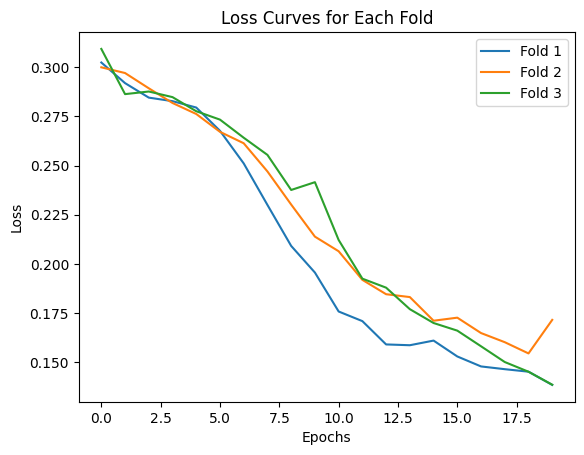

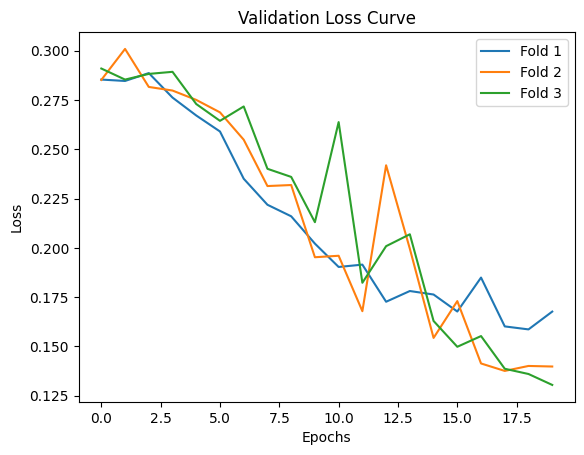

Average AUROC: 0.9496
Average Precision: 0.7189
Average Recall: 0.6556
Average F1 Score: 0.6835
Average Validation Loss: 0.2160


In [15]:
thresh_1=0.5

X1, X2, y = train_graph_data_p1, train_graph_data_p2, train_graph_data_interaction
model = cross_validate_model(X1, X2, y, batch_size=16, epochs=20, learning_rate=0.001, k_folds=3, thresh_1=thresh_1)

In [21]:
# Testing loop
def test_model(model, test_loader, thresh_1 = 0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print('Device:',device)
    model.eval()
    all_labels = []
    all_preds = []
    test_losses = []
    y_true_test = []
    y_pred_test = []
    criterion = torch.nn.BCELoss()

    with torch.no_grad():
        for data1, data2, label in test_loader:
            data1.x = data1.x.float(); data2.x = data2.x.float()
            label = label.float()  # Ensure labels have shape [batch_size, 1]

            data1 = data1.to(device)
            data2 = data2.to(device)
            label = label.to(device)

            outputs = model(data1, data2)  # Assuming model applies sigmoid
            outputs = outputs.view(-1)  # Always keeps it as a 1D tensor

            loss = criterion(outputs, label)  # Calculate loss for the validation batch
            test_losses.append(loss.item())  # Append to val_losses list

            # Collect true labels and predictions for metrics
            y_true_test.extend(label.cpu().numpy())
            y_pred_test.extend(outputs.detach().cpu().numpy())  # Directly use outputs (already sigmoid)

    # Convert to binary predictions for validation metrics
    y_pred_val_binary = [1 if p > thresh_1 else 0 for p in y_pred_test]

    # Calculate validation metrics
    test_precision = precision_score(y_true_test, y_pred_val_binary, zero_division=0)
    test_recall = recall_score(y_true_test, y_pred_val_binary, zero_division=0)
    test_f1 = f1_score(y_true_test, y_pred_val_binary, zero_division=0)
    test_auroc = roc_auc_score(y_true_test, y_pred_test)

    # Print validation metrics after every epoch
    print(f"Test - Loss: {sum(test_losses) / len(test_losses):.4f}, "
          f"AUROC: {test_auroc:.4f}, Precision: {test_precision:.4f}, "
          f"Recall: {test_recall:.4f}, F1: {test_f1:.4f}")

test_dataset = PPI_GraphDataset(test_graph_data_p1, test_graph_data_p2, test_graph_data_interaction)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)
test_model(model, test_loader, thresh_1=thresh_1)

Device: cuda
Test - Loss: 0.2053, AUROC: 0.9129, Precision: 0.7867, Recall: 0.6629, F1: 0.7195
